In [1]:
# This cell installs the required libraries for spell checking.
# In Kaggle, you need to enable "Internet" in the settings panel on the right.
!pip install pyenchant
!pip install pyspellchecker
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.6 MB/s eta 0:00:0000:0100:01


## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from spellchecker import SpellChecker

In [3]:
# Define the paths for training and testing data based on your folder structure
BASE_DIR = '/kaggle/input/dataset/dataSet/'
TRAIN_DIR = os.path.join(BASE_DIR, 'trainingData')
TEST_DIR = os.path.join(BASE_DIR, 'testingData') # We will use this for validation

# Directory to save the trained model
MODEL_SAVE_DIR = '/kaggle/working/'
MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'sign_language_model.pth')

# Define constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Training data will be loaded from: {TRAIN_DIR}")
print(f"Validation data will be loaded from: {TEST_DIR}")

Using device: cuda
Training data will be loaded from: /kaggle/input/dataset/dataSet/trainingData
Validation data will be loaded from: /kaggle/input/dataset/dataSet/testingData


## Create Data Augmentation

In [4]:
# Define transformations for the training and validation data
# For training data, we add augmentation to make the model more robust
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(), # This also normalizes pixel values to [0, 1]
])

# For validation data, we only need to resize and convert to a tensor
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

# Create datasets using ImageFolder for each directory
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

# Create DataLoaders to handle batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get class names and number of classes
class_names = train_dataset.classes
num_classes = len(class_names)
print("Found the following classes:", class_names)
print(f"There are {num_classes} classes.")

Found the following classes: ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
There are 27 classes.


## Designing CNN model

In [5]:
class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten()
        # The input features to the linear layer needs to be calculated
        # After 3 pooling layers, 128x128 becomes 16x16.
        # So, 128 channels * 16 * 16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the selected device
model = SignLanguageCNN(num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

SignLanguageCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=27, bias=True)
  (relu): ReLU()
)


## Training Loop

In [6]:
num_epochs = 20
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_bar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{(predicted == labels).sum().item()/labels.size(0):.4f}')

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    
    # --- Validation Phase ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_bar.set_postfix(loss=f'{loss.item():.4f}')
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = correct_val / total_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

print('Finished Training')

Epoch 1/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 1/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.1900, Train Acc: 0.6442 | Val Loss: 0.1298, Val Acc: 0.9667


Epoch 2/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 2/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3134, Train Acc: 0.8996 | Val Loss: 0.0111, Val Acc: 0.9993


Epoch 3/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 3/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.1887, Train Acc: 0.9401 | Val Loss: 0.0038, Val Acc: 0.9993


Epoch 4/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 4/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1360, Train Acc: 0.9555 | Val Loss: 0.0030, Val Acc: 0.9998


Epoch 5/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 5/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.0948, Train Acc: 0.9688 | Val Loss: 0.0012, Val Acc: 0.9995


Epoch 6/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 6/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.0866, Train Acc: 0.9718 | Val Loss: 0.0005, Val Acc: 0.9998


Epoch 7/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 7/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0856, Train Acc: 0.9710 | Val Loss: 0.0005, Val Acc: 1.0000


Epoch 8/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 8/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0672, Train Acc: 0.9791 | Val Loss: 0.0006, Val Acc: 0.9998


Epoch 9/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 9/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0567, Train Acc: 0.9801 | Val Loss: 0.0009, Val Acc: 0.9998


Epoch 10/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 10/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0547, Train Acc: 0.9816 | Val Loss: 0.0005, Val Acc: 0.9995


Epoch 11/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 11/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0440, Train Acc: 0.9861 | Val Loss: 0.0001, Val Acc: 1.0000


Epoch 12/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 12/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0390, Train Acc: 0.9876 | Val Loss: 0.0004, Val Acc: 0.9998


Epoch 13/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 13/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0438, Train Acc: 0.9860 | Val Loss: 0.0003, Val Acc: 0.9998


Epoch 14/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 14/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0348, Train Acc: 0.9886 | Val Loss: 0.0003, Val Acc: 1.0000


Epoch 15/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 15/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0263, Train Acc: 0.9907 | Val Loss: 0.0004, Val Acc: 0.9998


Epoch 16/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 16/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0317, Train Acc: 0.9895 | Val Loss: 0.0005, Val Acc: 0.9998


Epoch 17/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 17/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0327, Train Acc: 0.9881 | Val Loss: 0.0000, Val Acc: 1.0000


Epoch 18/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 18/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0287, Train Acc: 0.9911 | Val Loss: 0.0000, Val Acc: 1.0000


Epoch 19/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 19/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0223, Train Acc: 0.9924 | Val Loss: 0.0000, Val Acc: 1.0000


Epoch 20/20 [Training]:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 20/20 [Validation]:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0256, Train Acc: 0.9918 | Val Loss: 0.0000, Val Acc: 1.0000
Finished Training


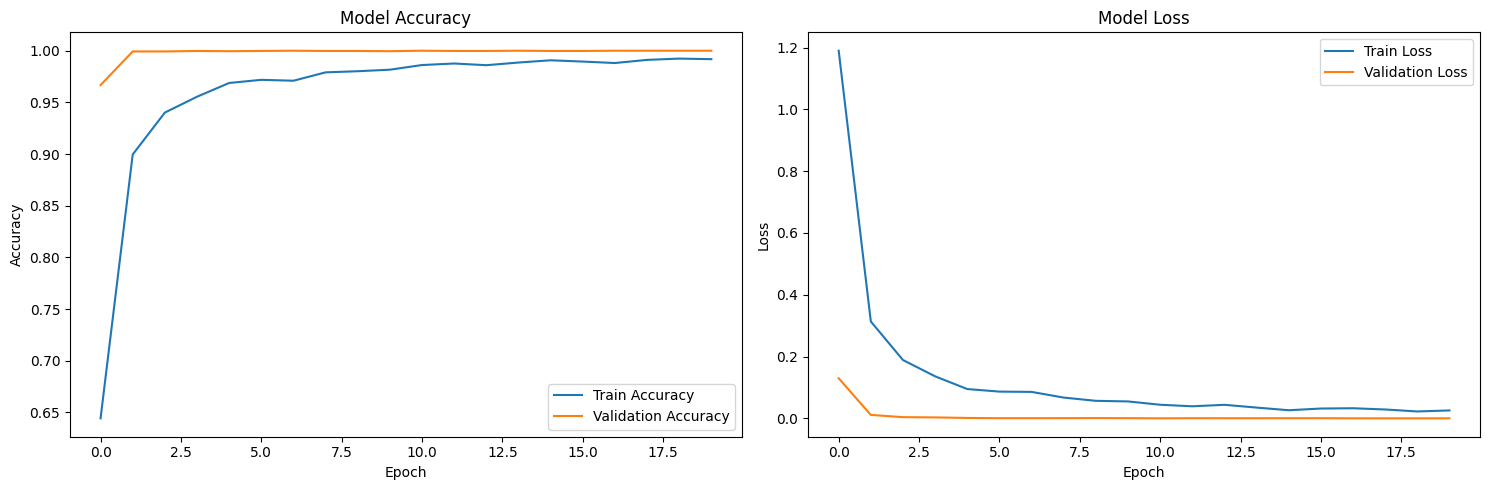

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history['train_acc'], label='Train Accuracy')
ax1.plot(history['val_acc'], label='Validation Accuracy')
ax1.set_title('Model Accuracy'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy'); ax1.legend(loc='lower right')
ax2.plot(history['train_loss'], label='Train Loss')
ax2.plot(history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss'); ax2.legend(loc='upper right')
plt.tight_layout(); plt.show()

In [8]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /kaggle/working/sign_language_model.pth


In [12]:
# Create a new model instance and load the weights
loaded_model = SignLanguageCNN(num_classes).to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

# Instantiate the spell checker
spell = SpellChecker()

def predict_from_frame(frame):
    """
    This function now processes the ENTIRE frame instead of a faulty ROI,
    and then predicts the sign.
    """
    # --- MODIFIED ROI ---
    # Instead of cropping a small region, we will now use the entire frame.
    # This assumes the sign is the main subject of the image, which is true for the test data.
    roi = frame
    # --- END OF MODIFICATION ---
    
    # We still flip the image as in the original logic, just in case
    roi = cv2.flip(roi, 1)

    # 4. Convert to grayscale and apply thresholds (same as original script)
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 2)
    th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    ret, processed_img = cv2.threshold(th3, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 5. Prepare image for PyTorch model
    pil_img = Image.fromarray(processed_img)
    input_tensor = data_transforms(pil_img).unsqueeze(0).to(device)

    # 6. Make prediction
    with torch.no_grad():
        output = loaded_model(input_tensor)
    _, predicted_idx = torch.max(output, 1)
    
    predicted_char = class_names[predicted_idx.item()]
    
    return predicted_char, processed_img

Model loaded successfully for prediction.


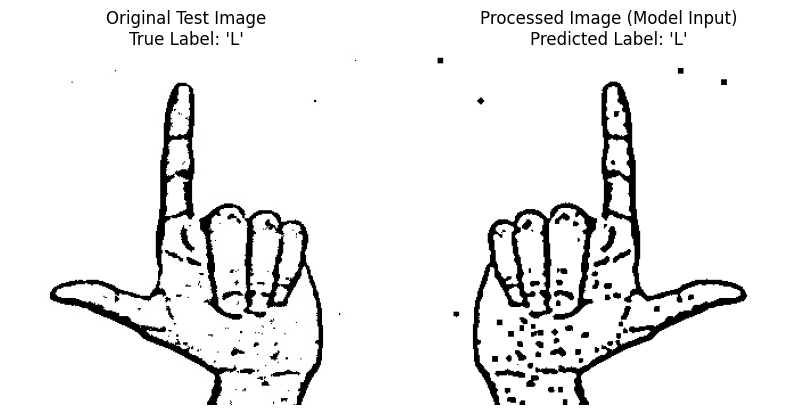

Current Word: 'L'
Current Sentence: ''
--------------------------------------------------


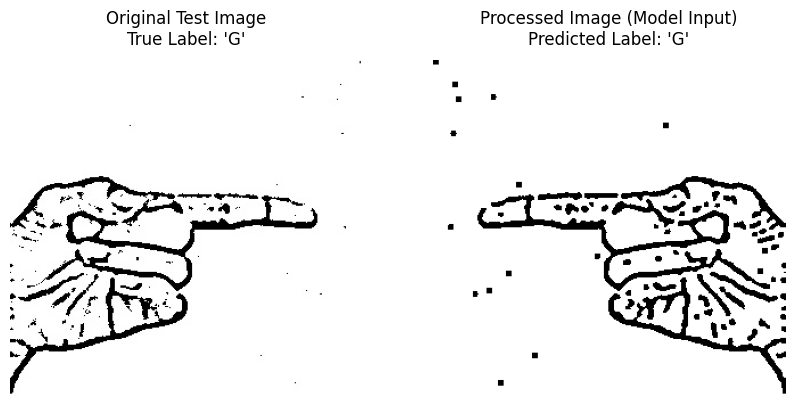

Current Word: 'LG'
Current Sentence: ''
Suggestions for 'LG': ['eg', 'log', 'l']
--------------------------------------------------


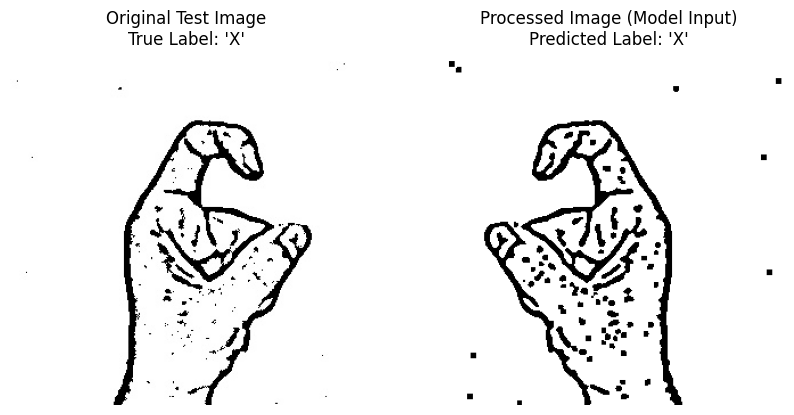

Current Word: 'LGX'
Current Sentence: ''
Suggestions for 'LGX': ['lx', 'lax', 'lux']
--------------------------------------------------


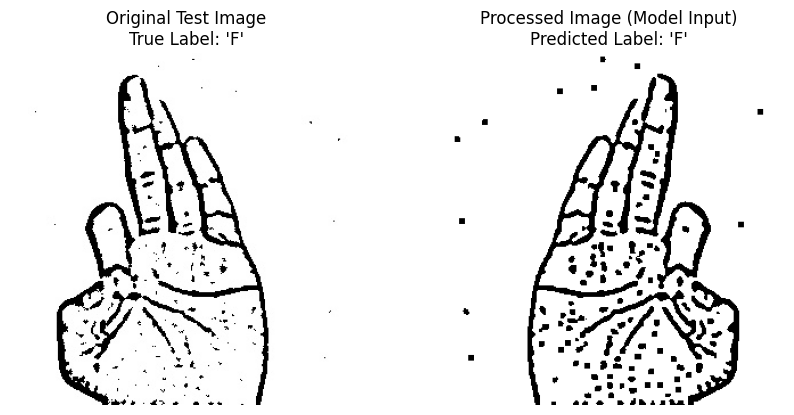

Current Word: 'LGXF'
Current Sentence: ''
Suggestions for 'LGXF': ['luff', 'lx', 'luxe']
--------------------------------------------------


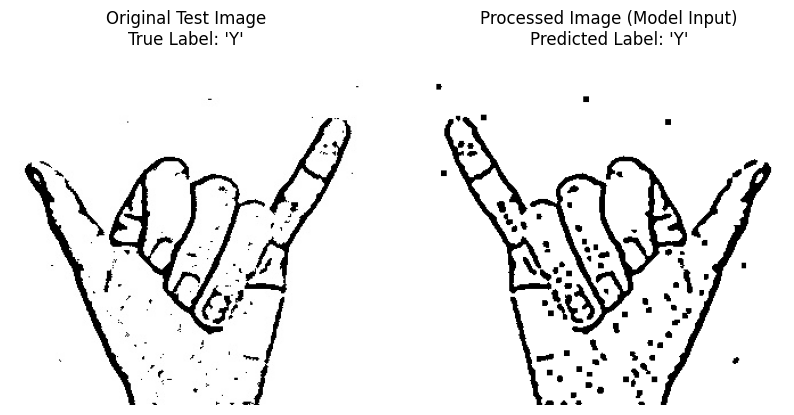

Current Word: 'LGXFY'
Current Sentence: ''
Suggestions for 'LGXFY': ['laxly', 'leafy']
--------------------------------------------------


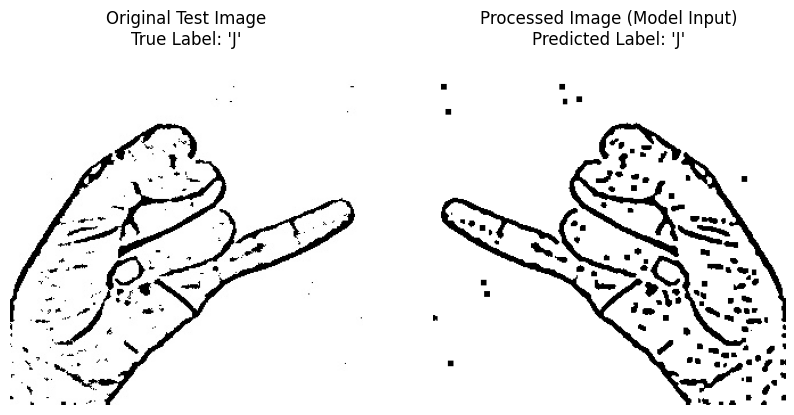

Current Word: 'LGXFYJ'
Current Sentence: ''
Suggestions for 'LGXFYJ': []
--------------------------------------------------


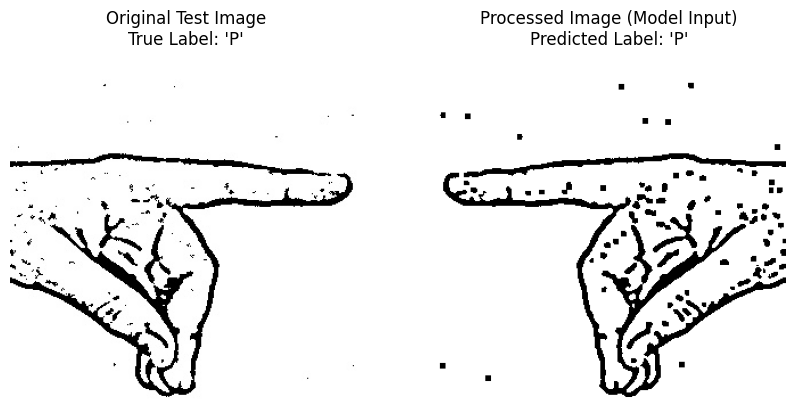

Current Word: 'LGXFYJP'
Current Sentence: ''
Suggestions for 'LGXFYJP': []
--------------------------------------------------


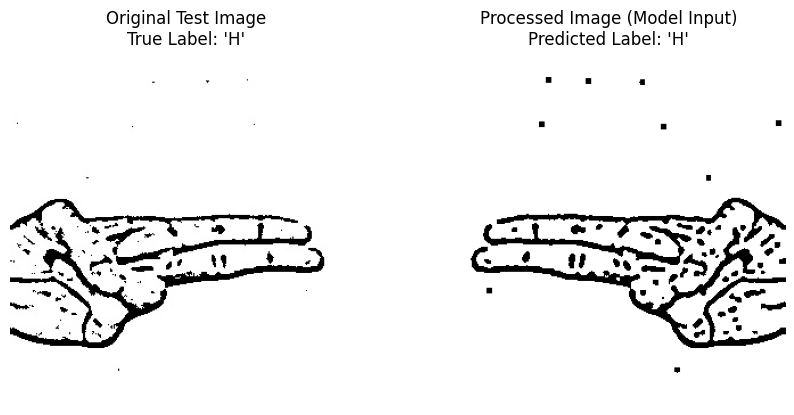

Current Word: 'LGXFYJPH'
Current Sentence: ''
Suggestions for 'LGXFYJPH': []
--------------------------------------------------


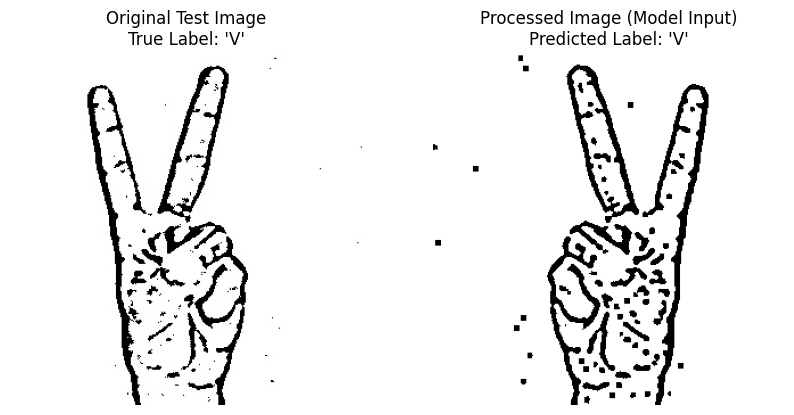

Current Word: 'LGXFYJPHV'
Current Sentence: ''
Suggestions for 'LGXFYJPHV': []
--------------------------------------------------


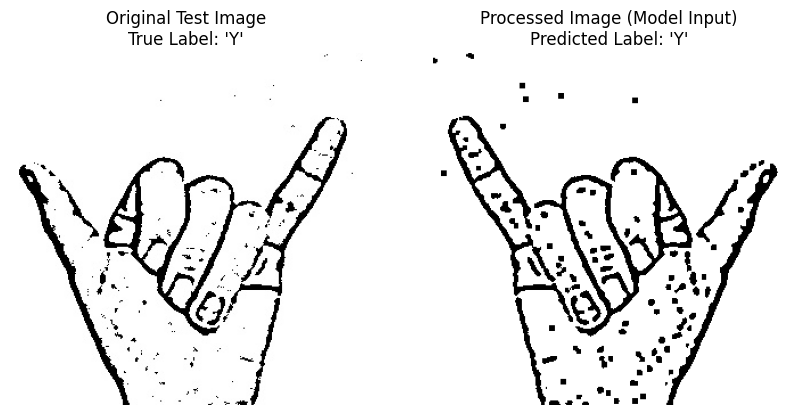

Current Word: 'LGXFYJPHVY'
Current Sentence: ''
Suggestions for 'LGXFYJPHVY': []
--------------------------------------------------

----------------------------------------
FINAL SIMULATED SENTENCE: 'LGXFYJPHVY'
----------------------------------------


In [14]:
import random
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image

# --- Ensure all necessary variables are defined in this cell ---

# Re-define constants and transformations to make this cell self-contained
IMG_SIZE = (128, 128)
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

# --- Load the trained model and set to evaluation mode ---
try:
    # Create a new model instance and load the weights
    loaded_model = SignLanguageCNN(num_classes).to(device)
    loaded_model.load_state_dict(torch.load(MODEL_PATH))
    loaded_model.eval()
    print("Model loaded successfully for prediction.")
except (NameError, FileNotFoundError):
    print("ERROR: Model could not be loaded. Please ensure all previous cells, including training, have been run successfully.")
    raise

# --- Instantiate the spell checker ---
spell = SpellChecker()

# --- Define the corrected prediction function ---
def predict_from_frame(frame):
    """
    This function now processes the ENTIRE frame instead of a faulty ROI,
    and then predicts the sign.
    """
    # Use the entire frame as the Region of Interest
    roi = frame
    
    # Flip the image as in the original logic
    roi = cv2.flip(roi, 1)

    # Convert to grayscale and apply thresholds
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 2)
    th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    ret, processed_img = cv2.threshold(th3, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Prepare image for PyTorch model
    pil_img = Image.fromarray(processed_img)
    input_tensor = data_transforms(pil_img).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = loaded_model(input_tensor)
    _, predicted_idx = torch.max(output, 1)
    
    predicted_char = class_names[predicted_idx.item()]
    
    return predicted_char, processed_img


# --- Simulate the logic and generate output ---
current_symbol, word, sentence, blank_flag = "", "", "", 0
all_image_tuples = val_dataset.imgs
num_images_to_simulate = min(10, len(all_image_tuples))
random_image_tuples = random.sample(all_image_tuples, num_images_to_simulate)

for img_path, true_label_idx in random_image_tuples:
    true_label = class_names[true_label_idx]
    frame = cv2.imread(img_path)
    if frame is None: continue
    
    predicted_char, processed_img = predict_from_frame(frame)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); ax1.set_title(f"Original Test Image\nTrue Label: '{true_label}'"); ax1.axis('off')
    ax2.imshow(processed_img, cmap='gray'); ax2.set_title(f"Processed Image (Model Input)\nPredicted Label: '{predicted_char}'"); ax2.axis('off')
    plt.show()
    
    # Logic to form words
    if predicted_char in ['blank', '0']:
        if blank_flag == 0:
            blank_flag = 1
            if len(word) > 0: sentence += " " + word
            word = ""
    else:
        blank_flag = 0
        word += predicted_char

    print(f"Current Word: '{word}'"); print(f"Current Sentence: '{sentence.strip()}'")
    
    # Spelling suggestion logic
    if len(word) > 1:
        candidates = spell.candidates(word)
        if candidates: print(f"Suggestions for '{word}': {list(candidates)[:3]}")
        else: print(f"Suggestions for '{word}': []")
    print("-" * 50)

if len(word) > 0: sentence += " " + word
print(f"\n----------------------------------------\nFINAL SIMULATED SENTENCE: '{sentence.strip()}'\n----------------------------------------")

## OLD ROI CODE

In [ ]:
# def predict_from_frame_OLD_ROI(frame):
#     """
#     This is the PREVIOUS version of the function containing the faulty,
#     hardcoded Region of Interest (ROI) logic.
#     """
#     # The image is flipped first
#     cv2image = cv2.flip(frame, 1)

#     # --- THIS IS THE OLD, PROBLEMATIC ROI CODE ---
#     # It defines a static box in the top-right corner of the frame.
#     x1 = int(0.5 * frame.shape[1])  # Start halfway across the width
#     y1 = 10                         # Start 10 pixels from the top
#     x2 = frame.shape[1] - 10        # End 10 pixels from the right edge
#     y2 = int(0.5 * frame.shape[1])  # End halfway down the height

#     # The image is cropped to this static box
#     roi = cv2image[y1:y2, x1:x2]
#     # --- END OF OLD ROI CODE ---

#     # The rest of the processing happens on this small, potentially incorrect crop
#     gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (5, 5), 2)
#     th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
#     ret, processed_img = cv2.threshold(th3, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#     # Prepare image for PyTorch model
#     pil_img = Image.fromarray(processed_img)
#     input_tensor = data_transforms(pil_img).unsqueeze(0).to(device)

#     # Make prediction
#     with torch.no_grad():
#         output = loaded_model(input_tensor)
#     _, predicted_idx = torch.max(output, 1)
    
#     predicted_char = class_names[predicted_idx.item()]
    
#     return predicted_char, processed_img